<a href="https://colab.research.google.com/github/rgilyard/predict-student-outcomes/blob/main/prelim_gaussian_process_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Results for a Gaussian Process Classifier for Student Failure and Dropout Prediction

## Constants

In [1]:
DATA_PATH = '/content/drive/MyDrive/COMP 542 Group Project/data/prelim_sample_engineered_student_info_large.csv'

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [3]:
import pandas as pd
import time
from joblib import dump
from datetime import datetime

## Load data

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
print(df.head())

   id_student gender                region      highest_education imd_band  \
0       11391      M   East Anglian Region       HE Qualification  90-100%   
1       28400      F              Scotland       HE Qualification   20-30%   
2       30268      F  North Western Region  A Level or Equivalent   30-40%   
3       31604      F     South East Region  A Level or Equivalent   50-60%   
4       32885      F  West Midlands Region     Lower Than A Level   50-60%   

  age_band  num_of_prev_attempts  studied_credits disability final_result  \
0     55<=                     0              240          N         Pass   
1    35-55                     0               60          N         Pass   
2    35-55                     0               60          Y    Withdrawn   
3    35-55                     0               60          N         Pass   
4     0-35                     0               60          N         Pass   

  course_instance  early_assessment_avg  
0       AAA_2013J         

In [6]:
# Drop id column
df.drop(['id_student'], axis=1, inplace=True)

## Preprocessing (These will be moved to a .py file later)

### Combine fail/withdraw and pass/distinction for binary prediction (at first)

In [7]:
df['fail'] = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)

### Split into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['final_result', 'fail'], axis=1)  # Dropping the target columns
y = df['fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9001)

### Missing values

In [9]:
# Check how many values are missing
print(X_train.isnull().sum())

gender                    0
region                    0
highest_education         0
imd_band                862
age_band                  0
num_of_prev_attempts      0
studied_credits           0
disability                0
course_instance           0
early_assessment_avg     43
dtype: int64


In [10]:
# Since there are not too many missing values, we can take the mode for imd_band
X_train['imd_band'].fillna(X_train['imd_band'].mode()[0], inplace=True)
X_test['imd_band'].fillna(X_test['imd_band'].mode()[0], inplace=True)

# Mean imputation for early assessment grade average
X_train['early_assessment_avg'].fillna(X_train['early_assessment_avg'].mean(), inplace=True)
X_test['early_assessment_avg'].fillna(X_test['early_assessment_avg'].mean(), inplace=True)

print(X_train.isnull().sum())

gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
course_instance         0
early_assessment_avg    0
dtype: int64


### Label encode binary features

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [12]:
# Lists for each type of feature to encode
# List of binary columns
binary = ['gender', 'disability']

# List of categorical columns
categorical = ['course_instance', 'region']

# List of ordinal columns
ordinal = {'highest_education': [\
              'No Formal quals', \
              'Lower Than A Level', \
              'A Level or Equivalent', \
              'HE Qualification', \
              'Post Graduate Qualification'], \
           'imd_band': [\
              '0-10%', \
              '10-20', \
              '20-30%', \
              '30-40%', \
              '40-50%', \
              '50-60%', \
              '60-70%', \
              '70-80%', \
              '80-90%', \
              '90-100%'], \
           'age_band': [\
              '0-35', \
              '35-55', \
              '55<=']}

In [13]:
# Label encode binary features
label_encoder = LabelEncoder()

for feature in binary:
  label_encoder.fit(X_train[feature])
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [14]:
# Label encode ordinal features in order
for feature, order in ordinal.items():
  label_encoder = LabelEncoder()
  label_encoder.fit(order)
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [15]:
# One hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical)
X_test = pd.get_dummies(X_test, columns=categorical)

In [16]:
# Because there a some categories with very few instances,
# make sure all the features are in both sets
# Add the missing columns filled with zeros
for col in X_train.columns:
  if col not in X_test.columns:
    X_test[col] = 0

# Reorder test columns to match the order in training set
X_test = X_test[X_train.columns]

# Normalize data

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Gaussian Process Model

In [18]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [19]:
# Initialize the Kernel and the Classifiers
# kernel = 1.0 * RBF(1.0)  # RBF kernel with length scale of 1.0
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e+6))
gp_classifier = GaussianProcessClassifier(kernel=kernel)

In [20]:
# Time model training duration
start_time = time.time()
start_datetime = datetime.fromtimestamp(start_time)
print("Start time:", start_datetime.strftime('%Y-%m-%d %H:%M:%S'))
# Train model
gp_classifier = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
gp_classifier.fit(X_train, y_train)
# Record model train duration end time
end_time = time.time()

Start time: 2023-10-17 23:07:18


In [21]:
# Save model
# Get current date and time
now = datetime.now()
# Format datetime object to string
formatted_date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
# Append datetime to file name
model_name_with_datetime = f'/content/drive/MyDrive/COMP 542 Group Project/models/gaussian_20000_{formatted_date_time}.joblib'
dump(gp_classifier, model_name_with_datetime)

['/content/drive/MyDrive/COMP 542 Group Project/models/gaussian_20000_2023-10-18_06-23-21.joblib']

In [22]:
elapsed_time = end_time - start_time
print(f"Time taken for training: {elapsed_time:.2f} seconds")

Time taken for training: 26163.71 seconds


## Evaluate Model

In [23]:
# Evaluate Model
score = gp_classifier.score(X_test, y_test)
print("Model Accuracy: {:.2f}%".format(score * 100))

Model Accuracy: 71.81%


In [24]:
# Make Predictions
y_prob = gp_classifier.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

### ROC curve

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [26]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

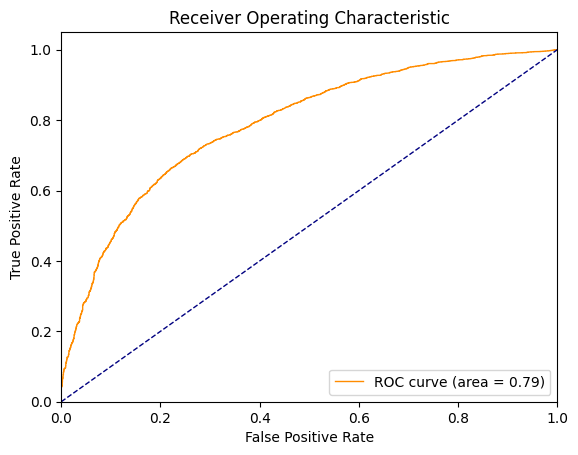

In [27]:
# Plot figure
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()